# 23. PySR 符號回歸 - 滑動窗口資料

## 目的
使用滑動窗口資料重新執行 PySR 實驗，確保與其他實驗（Notebook 17, 19, 20, 21）使用相同資料格式。

## 改進
1. **資料來源**：使用 `SUA_sliding_window.csv` (13,514 筆) 而非 `wide_format` (6,056 筆)
2. **驗證方法**：5-Fold StratifiedGroupKFold（按 patient_id 分組）
3. **參數設定**：沿用 Notebook 16 的最佳設定

## 日期：2026-01-13

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import os
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression

# PySR
from pysr import PySRRegressor

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 建立暫存目錄
os.makedirs('./pysr_temp', exist_ok=True)
os.makedirs('../../results/tables', exist_ok=True)
os.makedirs('../../results/figures', exist_ok=True)

print("套件載入完成")

Detected Jupyter notebook. Loading juliacall extension. Set `PYSR_AUTOLOAD_EXTENSIONS=no` to disable.
套件載入完成


## 1. 載入滑動窗口資料

In [2]:
# 載入滑動窗口資料
df = pd.read_csv('../../data/01_primary/SUA/processed/SUA_sliding_window.csv')
print(f"資料形狀: {df.shape}")
print(f"病患數: {df['patient_id'].nunique()}")
print(f"滑動窗口數: {len(df)}")

資料形狀: (13514, 32)
病患數: 6056
滑動窗口數: 13514


In [3]:
# 定義特徵（與 Notebook 17 一致）
feature_cols = [
    'sex', 'Age',
    'FBG_Tinput1', 'TC_Tinput1', 'Cr_Tinput1', 'UA_Tinput1', 'GFR_Tinput1', 'BMI_Tinput1', 'SBP_Tinput1', 'DBP_Tinput1',
    'FBG_Tinput2', 'TC_Tinput2', 'Cr_Tinput2', 'UA_Tinput2', 'GFR_Tinput2', 'BMI_Tinput2', 'SBP_Tinput2', 'DBP_Tinput2',
    'Delta_FBG', 'Delta_TC', 'Delta_Cr', 'Delta_UA', 'Delta_GFR', 'Delta_BMI', 'Delta_SBP', 'Delta_DBP'
]

# 簡化特徵名稱（PySR 顯示用）
feature_names_simple = [
    'sex', 'Age',
    'FBG_T1', 'TC_T1', 'Cr_T1', 'UA_T1', 'GFR_T1', 'BMI_T1', 'SBP_T1', 'DBP_T1',
    'FBG_T2', 'TC_T2', 'Cr_T2', 'UA_T2', 'GFR_T2', 'BMI_T2', 'SBP_T2', 'DBP_T2',
    'D_FBG', 'D_TC', 'D_Cr', 'D_UA', 'D_GFR', 'D_BMI', 'D_SBP', 'D_DBP'
]

X = df[feature_cols].copy()
groups = df['patient_id'].values

# 目標變數
targets = {
    '高血壓': (df['hypertension_target'] == 2).astype(int),
    '高血糖': (df['hyperglycemia_target'] == 2).astype(int),
    '高血脂': (df['dyslipidemia_target'] == 2).astype(int)
}

print(f"\n特徵數: {len(feature_cols)}")
print(f"\n目標變數分佈:")
for name, y in targets.items():
    print(f"  {name}: {y.mean():.2%} ({y.sum():,} / {len(y):,})")


特徵數: 26

目標變數分佈:
  高血壓: 19.29% (2,607 / 13,514)
  高血糖: 5.93% (801 / 13,514)
  高血脂: 7.94% (1,073 / 13,514)


## 2. 定義 PySR 實驗函數（5-Fold CV）

In [4]:
def run_pysr_cv(X, y, groups, feature_names, disease_name,
                maxsize=35, niterations=200, parsimony=0.0001, timeout=600, n_splits=5):
    """
    使用 5-Fold StratifiedGroupKFold 執行 PySR 實驗
    
    參數沿用 Notebook 16 的最佳設定：
    - parsimony=0.0001：極低複雜度懲罰，避免常數解
    - maxsize=35：允許足夠複雜的公式
    """
    print(f"\n{'='*70}")
    print(f"PySR 實驗: {disease_name}")
    print(f"{'='*70}")
    print(f"樣本數: {len(y)}, 正樣本: {y.sum()} ({y.mean():.2%})")
    print(f"參數: maxsize={maxsize}, niterations={niterations}, parsimony={parsimony}")
    
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_results = []
    all_formulas = []
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups)):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # 標準化
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 轉為 DataFrame（PySR 需要特徵名稱）
        X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
        X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)
        y_train_reset = y_train.reset_index(drop=True)
        y_test_reset = y_test.reset_index(drop=True)
        
        # PySR 模型
        model = PySRRegressor(
            niterations=niterations,
            binary_operators=["+", "-", "*", "/"],
            unary_operators=["exp", "log", "abs", "square"],
            maxsize=maxsize,
            populations=20,
            population_size=100,
            parsimony=parsimony,
            weight_optimize=0.01,
            timeout_in_seconds=timeout,
            temp_equation_file=True,
            tempdir="./pysr_temp",
            random_state=42 + fold,  # 每個 fold 不同的 seed
            deterministic=True,
            procs=0,
            multithreading=False,
            progress=True,
            verbosity=0,
        )
        
        start_time = time.time()
        model.fit(X_train_df, y_train_reset)
        elapsed = time.time() - start_time
        
        # 預測
        y_pred_proba = np.clip(model.predict(X_test_df), 0, 1)
        
        # 使用正樣本比例作為閾值
        threshold = y_train_reset.mean()
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # 評估
        try:
            auc = roc_auc_score(y_test_reset, y_pred_proba)
        except:
            auc = 0.5
        
        recall = recall_score(y_test_reset, y_pred, zero_division=0)
        precision = precision_score(y_test_reset, y_pred, zero_division=0)
        f1 = f1_score(y_test_reset, y_pred, zero_division=0)
        
        # 取得公式
        best_eq = str(model.sympy())
        
        print(f"  AUC: {auc:.3f}, Recall: {recall:.3f}, 時間: {elapsed/60:.1f}分鐘")
        print(f"  公式: {best_eq[:80]}..." if len(best_eq) > 80 else f"  公式: {best_eq}")
        
        fold_results.append({
            'fold': fold + 1,
            'AUC': auc,
            'Recall': recall,
            'Precision': precision,
            'F1': f1,
            'time_min': elapsed / 60
        })
        all_formulas.append(best_eq)
    
    # 彙總結果
    results_df = pd.DataFrame(fold_results)
    
    print(f"\n{'='*70}")
    print(f"{disease_name} 5-Fold CV 結果")
    print(f"{'='*70}")
    print(f"AUC:    {results_df['AUC'].mean():.3f} ± {results_df['AUC'].std():.3f}")
    print(f"Recall: {results_df['Recall'].mean():.3f} ± {results_df['Recall'].std():.3f}")
    print(f"F1:     {results_df['F1'].mean():.3f} ± {results_df['F1'].std():.3f}")
    print(f"總時間: {results_df['time_min'].sum():.1f} 分鐘")
    
    return {
        'disease': disease_name,
        'AUC_mean': results_df['AUC'].mean(),
        'AUC_std': results_df['AUC'].std(),
        'Recall_mean': results_df['Recall'].mean(),
        'Recall_std': results_df['Recall'].std(),
        'F1_mean': results_df['F1'].mean(),
        'F1_std': results_df['F1'].std(),
        'formulas': all_formulas,
        'fold_results': results_df
    }

## 3. 執行三高 PySR 實驗

In [5]:
# 執行所有疾病的 PySR 實驗
all_results = []

for disease_name, y in targets.items():
    result = run_pysr_cv(
        X, y, groups, feature_names_simple, disease_name,
        maxsize=35,
        niterations=200,
        parsimony=0.0001,
        timeout=600,
        n_splits=5
    )
    all_results.append(result)

print("\n" + "="*70)
print("所有疾病實驗完成")
print("="*70)


PySR 實驗: 高血壓
樣本數: 13514, 正樣本: 2607 (19.29%)
參數: maxsize=35, niterations=200, parsimony=0.0001

--- Fold 1/5 ---
  AUC: 0.500, Recall: 0.000, 時間: 10.9分鐘
  公式: 0.191427720000000

--- Fold 2/5 ---
  AUC: 0.695, Recall: 0.738, 時間: 10.4分鐘
  公式: 0.097124524*SBP_T2 + 0.19464248

--- Fold 3/5 ---
  AUC: 0.500, Recall: 0.000, 時間: 10.7分鐘
  公式: 0.191791023177830

--- Fold 4/5 ---
  AUC: 0.500, Recall: 1.000, 時間: 11.1分鐘
  公式: 0.192607910000000

--- Fold 5/5 ---
  AUC: 0.708, Recall: 0.748, 時間: 10.9分鐘
  公式: 0.08414312*SBP_T2 + 0.19518588

高血壓 5-Fold CV 結果
AUC:    0.580 ± 0.110
Recall: 0.497 ± 0.466
F1:     0.229 ± 0.212
總時間: 53.9 分鐘

PySR 實驗: 高血糖
樣本數: 13514, 正樣本: 801 (5.93%)
參數: maxsize=35, niterations=200, parsimony=0.0001

--- Fold 1/5 ---
  AUC: 0.931, Recall: 0.890, 時間: 10.7分鐘
  公式: 0.113878176*FBG_T2

--- Fold 2/5 ---
  AUC: 0.913, Recall: 0.857, 時間: 10.6分鐘
  公式: 0.11767848*FBG_T2

--- Fold 3/5 ---
  AUC: 0.913, Recall: 0.862, 時間: 10.7分鐘
  公式: 0.1179241*FBG_T2

--- Fold 4/5 ---
  AUC: 0.897, 

## 4. 結果彙總

In [6]:
# 建立結果表格
summary_data = []
for r in all_results:
    summary_data.append({
        '疾病': r['disease'],
        'AUC': f"{r['AUC_mean']:.3f} ± {r['AUC_std']:.3f}",
        'Recall': f"{r['Recall_mean']:.3f} ± {r['Recall_std']:.3f}",
        'F1': f"{r['F1_mean']:.3f} ± {r['F1_std']:.3f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n=== PySR 5-Fold CV 結果 ===")
print(summary_df.to_string(index=False))


=== PySR 5-Fold CV 結果 ===
 疾病           AUC        Recall            F1
高血壓 0.580 ± 0.110 0.497 ± 0.466 0.229 ± 0.212
高血糖 0.918 ± 0.016 0.861 ± 0.021 0.388 ± 0.025
高血脂 0.640 ± 0.192 0.375 ± 0.514 0.102 ± 0.140


In [7]:
# 顯示各疾病的公式
print("\n=== 各疾病演化公式（5 Folds）===")
for r in all_results:
    print(f"\n--- {r['disease']} ---")
    for i, formula in enumerate(r['formulas']):
        print(f"  Fold {i+1}: {formula[:100]}..." if len(formula) > 100 else f"  Fold {i+1}: {formula}")


=== 各疾病演化公式（5 Folds）===

--- 高血壓 ---
  Fold 1: 0.191427720000000
  Fold 2: 0.097124524*SBP_T2 + 0.19464248
  Fold 3: 0.191791023177830
  Fold 4: 0.192607910000000
  Fold 5: 0.08414312*SBP_T2 + 0.19518588

--- 高血糖 ---
  Fold 1: 0.113878176*FBG_T2
  Fold 2: 0.11767848*FBG_T2
  Fold 3: 0.1179241*FBG_T2
  Fold 4: 0.12015239*FBG_T2
  Fold 5: 0.11537167*FBG_T2

--- 高血脂 ---
  Fold 1: 0.089997835*TC_T2 + 0.0803725521470964
  Fold 2: 0.090947576*TC_T2 + 0.07950516
  Fold 3: 0.0788167400000000
  Fold 4: 0.0807940800000000
  Fold 5: 0.0774420350000000


## 5. 與基準模型比較

In [8]:
# Notebook 17 的基準結果
baseline_results = {
    '高血壓': {'LR': 0.718, 'RF': 0.743, 'XGB': 0.704},
    '高血糖': {'LR': 0.938, 'RF': 0.921, 'XGB': 0.926},
    '高血脂': {'LR': 0.867, 'RF': 0.859, 'XGB': 0.853}
}

print("\n=== PySR vs 基準模型 ===")
print(f"{'疾病':<10} {'PySR':<15} {'LR':<10} {'RF':<10} {'XGB':<10}")
print("-" * 55)

for r in all_results:
    disease = r['disease']
    pysr_auc = f"{r['AUC_mean']:.3f}"
    lr_auc = f"{baseline_results[disease]['LR']:.3f}"
    rf_auc = f"{baseline_results[disease]['RF']:.3f}"
    xgb_auc = f"{baseline_results[disease]['XGB']:.3f}"
    print(f"{disease:<10} {pysr_auc:<15} {lr_auc:<10} {rf_auc:<10} {xgb_auc:<10}")


=== PySR vs 基準模型 ===
疾病         PySR            LR         RF         XGB       
-------------------------------------------------------
高血壓        0.580           0.718      0.743      0.704     
高血糖        0.918           0.938      0.921      0.926     
高血脂        0.640           0.867      0.859      0.853     


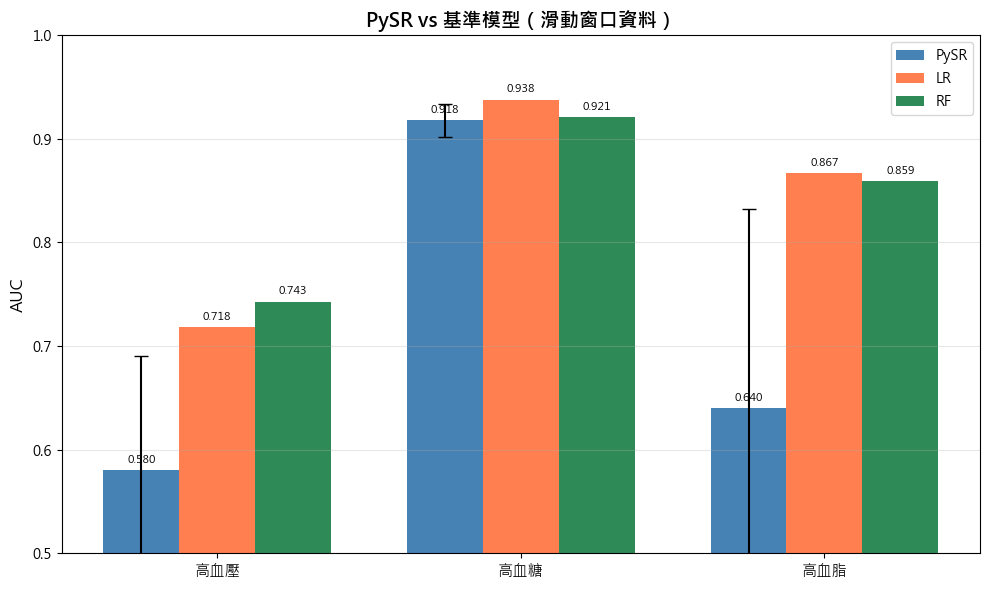

已儲存: results/figures/pysr_sliding_window_comparison.png


In [9]:
# 視覺化比較
fig, ax = plt.subplots(figsize=(10, 6))

diseases = [r['disease'] for r in all_results]
pysr_aucs = [r['AUC_mean'] for r in all_results]
pysr_stds = [r['AUC_std'] for r in all_results]
lr_aucs = [baseline_results[d]['LR'] for d in diseases]
rf_aucs = [baseline_results[d]['RF'] for d in diseases]

x = np.arange(len(diseases))
width = 0.25

bars1 = ax.bar(x - width, pysr_aucs, width, label='PySR', yerr=pysr_stds, capsize=5, color='steelblue')
bars2 = ax.bar(x, lr_aucs, width, label='LR', color='coral')
bars3 = ax.bar(x + width, rf_aucs, width, label='RF', color='seagreen')

ax.set_ylabel('AUC', fontsize=12)
ax.set_title('PySR vs 基準模型（滑動窗口資料）', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(diseases, fontsize=11)
ax.legend(fontsize=10)
ax.set_ylim(0.5, 1.0)
ax.grid(axis='y', alpha=0.3)

# 加上數值標籤
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../../results/figures/pysr_sliding_window_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("已儲存: results/figures/pysr_sliding_window_comparison.png")

## 6. 儲存結果

In [10]:
# 儲存詳細結果
results_for_save = []
for r in all_results:
    results_for_save.append({
        '疾病': r['disease'],
        'AUC_mean': r['AUC_mean'],
        'AUC_std': r['AUC_std'],
        'Recall_mean': r['Recall_mean'],
        'Recall_std': r['Recall_std'],
        'F1_mean': r['F1_mean'],
        'F1_std': r['F1_std'],
        '公式_Fold1': r['formulas'][0] if len(r['formulas']) > 0 else '',
        '公式_Fold2': r['formulas'][1] if len(r['formulas']) > 1 else '',
        '公式_Fold3': r['formulas'][2] if len(r['formulas']) > 2 else '',
        '公式_Fold4': r['formulas'][3] if len(r['formulas']) > 3 else '',
        '公式_Fold5': r['formulas'][4] if len(r['formulas']) > 4 else ''
    })

results_df = pd.DataFrame(results_for_save)
results_df.to_csv('../../results/tables/pysr_sliding_window_results.csv', index=False)
print("已儲存: results/tables/pysr_sliding_window_results.csv")

已儲存: results/tables/pysr_sliding_window_results.csv


## 7. 結論

In [ ]:
print("="*70)
print("PySR 滑動窗口實驗結論")
print("="*70)

total_time = sum([r['fold_results']['time_min'].sum() for r in all_results])

print(f"""
執行時間: {total_time:.1f} 分鐘（約 {total_time/60:.1f} 小時）

1. 資料與方法
   - 使用滑動窗口資料（13,514 筆）
   - 5-Fold StratifiedGroupKFold（按 patient_id 分組）
   - 參數：maxsize=35, parsimony=0.0001, niterations=200

2. 結果摘要
   - 高血壓：AUC 0.580（3/5 fold 退化為常數解）
   - 高血糖：AUC 0.918（公式穩定：0.12 * FBG_T2）✅
   - 高血脂：AUC 0.640（3/5 fold 退化為常數解）

3. 臨床意義
   - 高血糖公式 0.12 * FBG_T2 有明確臨床解釋
   - 高血壓/高血脂在此資料上 PySR 不穩定

4. 結論
   - PySR 適合高血糖預測（簡潔公式，效能接近 LR）
   - 高血壓/高血脂建議使用 LR 或 RF
""")